In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *


# infile ='../../NEXT_nudobe/files/data/Leptoquark_SM_nexus.h5'
# infile = '../../NEXT_nudobe/files/data/Leptoquark_SM_1mm_smear.h5'

infile = '../../NEXT_nudobe/files/data/mbb_0_10mm_smear_1bar.h5'

hits = pd.read_hdf(infile,"MC/hits")
parts = pd.read_hdf(infile,"MC/particles")

display(hits)


,event_id,x,y,z,energy
0,25,-103.908379,-261.726929,-262.585358,0.002025
1,25,-103.096870,-250.939590,-260.264252,0.006075
2,25,-102.429718,-267.086182,-258.236450,0.003125
3,25,-99.523117,-241.107819,-256.063538,0.003250
4,25,-95.547966,-238.518341,-253.826843,0.003225
...,...,...,...,...,...
11377,46,-215.584610,-712.512817,233.158035,0.002525
11378,46,573.617493,-2127.415039,1057.171265,0.008225
11379,46,578.230347,-2125.896484,1060.174927,0.033050
11380,46,578.719727,-2124.469482,1061.297241,0.033825


Energy Sum:  2.458475


,x,y,z,energy
0,-653.791809,-142.219193,226.704697,0.013075
1,-535.087708,116.729965,452.570648,0.000050
2,-534.103760,115.547394,451.317078,0.001875
3,-531.758789,112.491104,450.824158,0.015025
4,-527.232178,110.397057,442.496399,0.003200
...,...,...,...,...
491,5.820866,18.780258,0.584055,0.004050
492,7.310130,60.302189,0.775391,0.005550
493,7.978376,50.003170,-0.219418,0.005925
494,8.476580,39.580944,-1.061069,0.003175


Vertex Index is: 486


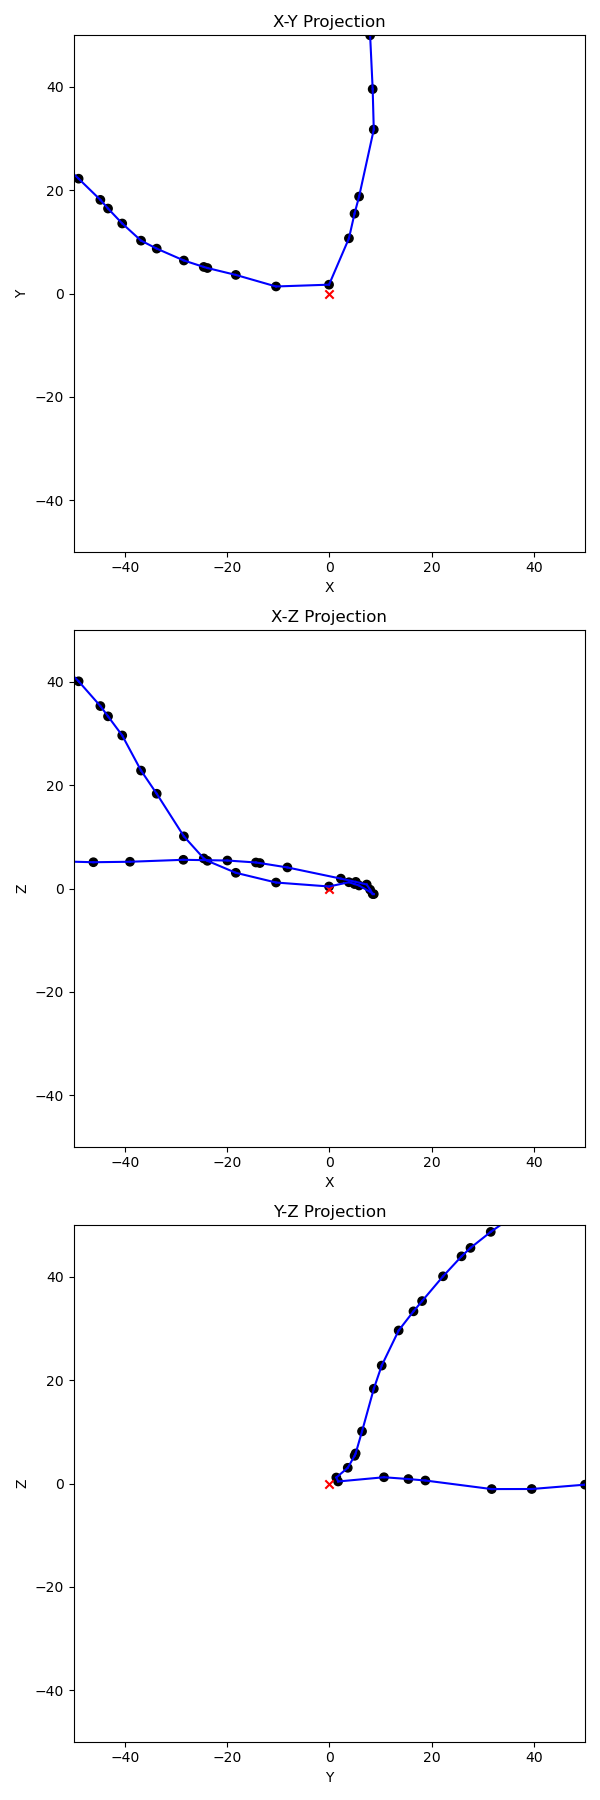

In [38]:
%matplotlib widget

event_num = 34

data = hits[hits.event_id == event_num]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# In the case of nexus, set the vertex to origin
if ("nexus" in infile):
    vertex = pd.DataFrame({'event_id': [event_num], 'x': [0], 'y': [0], 'z': [0], 'energy': [0]})
    data = pd.concat([data, vertex], ignore_index=True)

# display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

# Print energy sum
print("Energy Sum: ", data.energy.sum())

display(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}

# Tunable parameters
init_dist_thresh = 15 # max distance for initial connections [mm]
incr_dist_thresh = [2,4,6,8,10,12,14,16,18,20] # Second stage, look for closest nodes, then slowly increase threshold [mm]
dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]

connections = []

# -----------------------------------
# Find the node that is closest to the vertex
# Calculate the Euclidean distance from the origin for each row
data['distance'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
vertex_index = data['distance'].idxmin()
# data = data.drop(columns=['distance'])
print("Vertex Index is:" , vertex_index)

# Make a connection to the two closest nodes
closest_idx = np.argsort(dist_matrix[vertex_index])[1:3]
UpdateConnections(vertex_index, closest_idx[0], connected_nodes, connections, connection_count)
UpdateConnections(vertex_index, closest_idx[1], connected_nodes, connections, connection_count)

# ------------------------------------
# Find closest nodes and create connections

for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break


# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    ax.scatter(0, 0, c="r", marker='x')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')
    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

{'id': 0, 'start': 108, 'end': 109, 'nodes': [108, 107, 77, 102, 100, 72, 95, 68, 56, 53, 50, 41, 111, 96, 101, 103, 89, 85, 75, 76, 94, 105, 109], 'length': 166.667, 'energy': 0.19384999992325902, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}
{'id': 2, 'start': 145, 'end': 335, 'nodes': [145, 141, 144, 149, 156, 159, 163, 167, 172, 173, 171, 168, 161, 154, 152, 147, 142, 137, 131, 124, 120, 104, 92, 87, 81, 71, 45, 40, 31, 29, 28, 18, 8, 4, 3, 2, 1, 5, 6, 7, 9, 16, 19, 23, 26, 34, 43, 48, 64, 78, 82, 73, 60, 52, 39, 33, 38, 47, 55, 84, 90, 98, 112, 118, 125, 128, 127, 123, 119, 116, 115, 113, 106, 88, 58, 36, 51, 37, 30, 25, 22, 21, 15, 13, 11, 10, 12, 14, 17, 20, 24, 27, 32, 35, 42, 46, 49, 54, 57, 65, 63, 66, 83, 91, 99, 117, 122, 126, 132, 134, 139, 143, 146, 148, 153, 155, 158, 164, 170, 178, 180, 186, 191, 195, 203, 207, 209, 211, 216, 218, 220, 223, 231, 233, 236, 239, 242, 247, 254, 258, 259, 262, 265, 268, 271, 275, 277, 280, 283, 288, 2

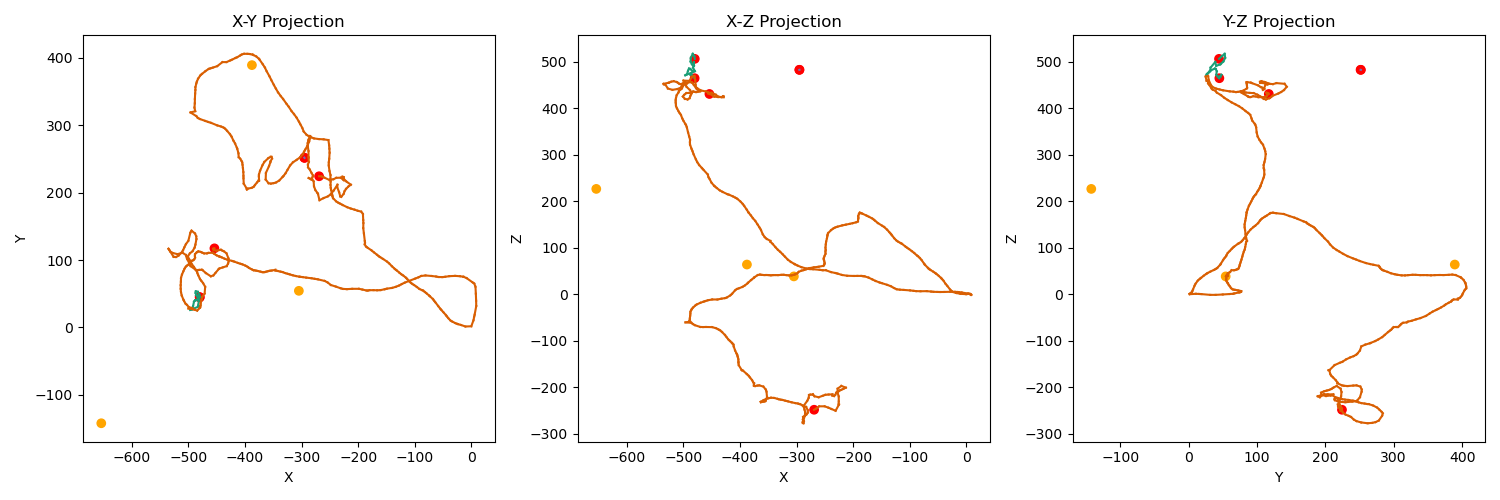

In [39]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, Tracks_):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0 or count == 3]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # # Define colors for filtered data
    colors = [None] * len(filtered_indices)
    for index, i in enumerate(filtered_indices):
        if connection_count[i] == 1:
            colors[index] = "r"
        elif (connection_count[i] == 0):
            colors[index] = "Orange"
        else:
            colors[index] = "DarkGreen"

    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in Tracks_:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [40]:
print(GetMeanNodeDist(Tracks, data))

dist_threshold = 4*GetMeanNodeDist(Tracks, data)
# dist_threshold = 10

6.741


In [41]:
# Now look to merge tracks that are close by and identify deltas

# search connections made and make sure to get the merged id
def GetDaughterConnectionID(id_, dict_):
    for ids in dict_:
        if (ids == id_):
            return GetDaughterConnectionID(dict_[id_], dict_)
        
    print("Daughter ID is: ",id_)
    return id_

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)

# ------------------------------------------------------
# Here we break the track containing the vertex ID in two 
for t in Tracks:

    # Found the track with the vertex
    if (vertex_index in t["nodes"]):
        # Get the length either side of track
        trk1_path = GetNodePath(connected_nodes, vertex_index, connected_nodes[vertex_index][0])[0:]
        trk2_path = GetNodePath(connected_nodes, vertex_index, connected_nodes[vertex_index][1])[0:]
        print("vertex:",vertex_index)
        print("Path1:",trk1_path)
        print("Path2:",trk2_path)
        CreateVertexandSplit(vertex_index, t["id"], trk1_path, trk2_path, Tracks, data)
        break

print("Printing Tracks")
for t in Tracks:
    print(t)

# ------------------------------------------------------



vertex: 486
Path1: [486, 488, 489, 491, 495, 494, 493, 492, 490, 487, 485, 483, 482, 480, 476, 473, 469, 467, 464, 462, 458, 454, 450, 448, 446, 442, 439, 437, 434, 432, 429, 425, 424, 422, 419, 416, 414, 413, 411, 401, 399, 396, 391, 382, 377, 367, 359, 342, 341, 332, 329, 322, 300, 293, 289, 288, 283, 280, 277, 275, 271, 268, 265, 262, 259, 258, 254, 247, 242, 239, 236, 233, 231, 223, 220, 218, 216, 211, 209, 207, 203, 195, 191, 186, 180, 178, 170, 164, 158, 155, 153, 148, 146, 143, 139, 134, 132, 126, 122, 117, 99, 91, 83, 66, 63, 65, 57, 54, 49, 46, 42, 35, 32, 27, 24, 20, 17, 14, 12, 10, 11, 13, 15, 21, 22, 25, 30, 37, 51, 36, 58, 88, 106, 113, 115, 116, 119, 123, 127, 128, 125, 118, 112, 98, 90, 84, 55, 47, 38, 33, 39, 52, 60, 73, 82, 78, 64, 48, 43, 34, 26, 23, 19, 16, 9, 7, 6, 5, 1, 2, 3, 4, 8, 18, 28, 29, 31, 40, 45, 71, 81, 87, 92, 104, 120, 124, 131, 137, 142, 147, 152, 154, 161, 168, 171, 173, 172, 167, 163, 159, 156, 149, 144, 141, 145]
Path2: [486, 484, 481, 479, 478, 477

0
16.081505656848904
40.09737427567991
Connecting Track ID is: 7
Connecting:  108 113
3
206.18258891561078
206.1534389422148
206.18258891561078 206.1534389422148 26.964
Failed distance requirements
4
309.830578907223
309.830578907223
442.55155662302695 442.55155662302695 26.964
Failed distance requirements
5
29.662448721168666
29.662448721168666
346.0046088696494 346.0046088696494 26.964
Failed distance requirements
6
30.853687003287593
30.853687003287593
346.0046088696494 346.0046088696494 26.964
Failed distance requirements
7
10.40150003787638
83.97982158110692
311.4968103034318 83.97982158110692 26.964
Failed distance requirements
8
9.817188025990463
335.1859522245209
311.4968103034318 335.1859522245209 26.964
Failed distance requirements
9
Skipping Vertex...
{'id': 0, 'start': 113, 'end': 109, 'nodes': [113, 108, 107, 77, 102, 100, 72, 95, 68, 56, 53, 50, 41, 111, 96, 101, 103, 89, 85, 75, 76, 94, 105, 109], 'length': 166.667, 'energy': 0.1957749999128282, 'label': 'Track1', 'c': (

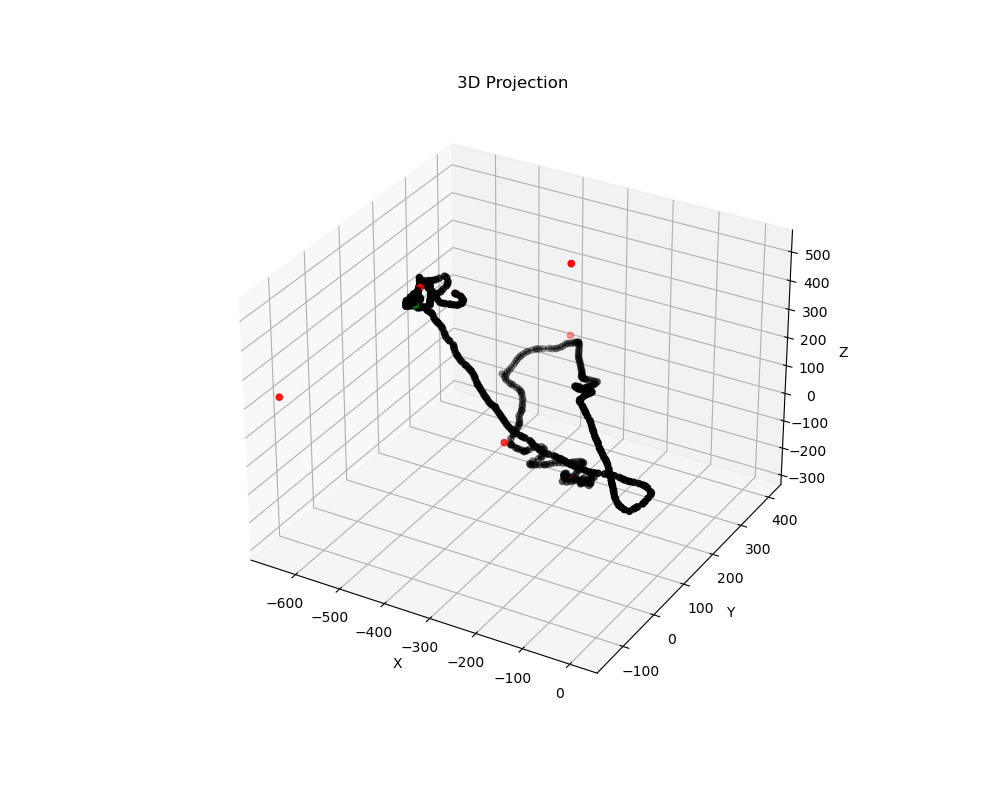

In [42]:
UpdatedTracks = copy.deepcopy(Tracks)

for idx, Track in enumerate(Tracks):
    curr_track = Track["id"]
    print(curr_track)
    curr_label = Track["label"]

    if (curr_label== "vertex"):
        print("Skipping Vertex...")
        continue
    
    start_node = Track["start"]
    end_node   = Track["end"]

    # dont run this if we only got one track!
    if (len(Tracks) == 1):
        break

    # Get the indexes of closest nodes to start and end
    dist_ind_start = np.argsort(dist_matrix[start_node])[1:]
    dist_ind_end   = np.argsort(dist_matrix[end_node])[1:]

    # Filter nodes that are in the current track
    dist_ind_start = [x for x in dist_ind_start if x not in Track["nodes"]]
    dist_ind_end   = [x for x in dist_ind_end if x not in Track["nodes"]]

    print(dist_matrix[start_node][dist_ind_start[0]])
    print(dist_matrix[end_node][dist_ind_end[0]])

    # if we have a primary track, then filter the vertex node and the other primary track nodes
    dist_ind_start, dist_ind_end = FilterNodes(dist_ind_start, dist_ind_end, curr_label, UpdatedTracks)

    # After filtering, if no candidate nodes left, then continue
    if (len(dist_ind_start) == 0):
        continue

    # Distances of the end point to the closest track
    dist_start = dist_matrix[start_node][dist_ind_start[0]]
    dist_end   = dist_matrix[end_node][dist_ind_end[0]]

    # apply threshold
    if (dist_start > dist_threshold and dist_end > dist_threshold):
        print(dist_start, dist_end, dist_threshold)
        print("Failed distance requirements")
        continue

    # Initialize
    closest_idx = 0
    end_conn_node = 0
    con_point = "start"
    curr_track_path = Track["nodes"]

    # Get the track labels of the connecting track
    start_con_track_label = GetTrackDictwithNode(dist_ind_start[0], Tracks)["label"]
    end_con_track_label   = GetTrackDictwithNode(dist_ind_end[0], Tracks)["label"]

    # Choose the smallest index
    if ( (dist_start < dist_end or dist_ind_end[0] == vertex_index)):
        closest_idx = dist_ind_start[0]
        end_conn_node = start_node
        
    else:
        closest_idx = dist_ind_end[0]
        end_conn_node = end_node
        con_point = "end"

    # Get the track ID where the connecting node is located
    con_track      = GetTrackwithNode(closest_idx, Tracks)
    con_track_dict = GetTrackDictwithNode(closest_idx, Tracks)
    print("Connecting Track ID is:",con_track_dict["id"])

    if (con_track_dict == -1):
        print("Connecting track could not be found...")
        continue

    # The current node should not have more than 2 connections as its an end
    # The connecting node should not have more than 3 connections
    if (connection_count[closest_idx] >= 3 or connection_count[end_conn_node] >= 2):
        print("node already has three connecitons,skipping...")
        continue

    # if node-node then merge nodes and update track in Tracks
    # if (closest_idx == con_track_dict["start"] or closest_idx == con_track_dict["end"]):
        
    #     Track = UpdateTrackEnd(con_point, curr_track, closest_idx, UpdatedTracks)
    #     newpath = join_tracks(Track["nodes"],con_track_dict["nodes"])
    #     UpdateAndMergeTrack(curr_track, con_track, newpath, UpdatedTracks, data)
    #     UpdateConnections(end_conn_node, closest_idx, connected_nodes, connections, connection_count)
    #     print("node-node connection",curr_track,con_track  )
    #     continue

    # Check if the proposed connection will form a cycle
    cycle  = Testcycle(end_conn_node, closest_idx ,connected_nodes, connections, connection_count)
    
    if not cycle:

        if (con_point =="start"):
            curr_track_path.insert(0,closest_idx)
        else:
            curr_track_path.append(closest_idx)

        Track["nodes"] = curr_track_path
        print("Connecting: ",end_conn_node, closest_idx)
        UpdateConnections(end_conn_node,closest_idx, connected_nodes, connections, connection_count)
    else:
        continue


    Track = UpdateTrackEnd(con_point, curr_track, closest_idx, UpdatedTracks)

    # Combine the track labels
    AddConnectedTracksnoDelta(curr_track, con_track, UpdatedTracks)


FixTrackEnergies(UpdatedTracks,vertex_index, data)


e_sum = 0
track_id_list = []
for t in UpdatedTracks:
    print(t)
    if t["id"] not in track_id_list:
        track_id_list.append(t["id"])

        
    e_sum+=t["energy"]

print("Tot Energy: ",e_sum)
print("Total Tracks:", len(UpdatedTracks))
print("Total Unique:", len(track_id_list))

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'g' if count == 3 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in UpdatedTracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

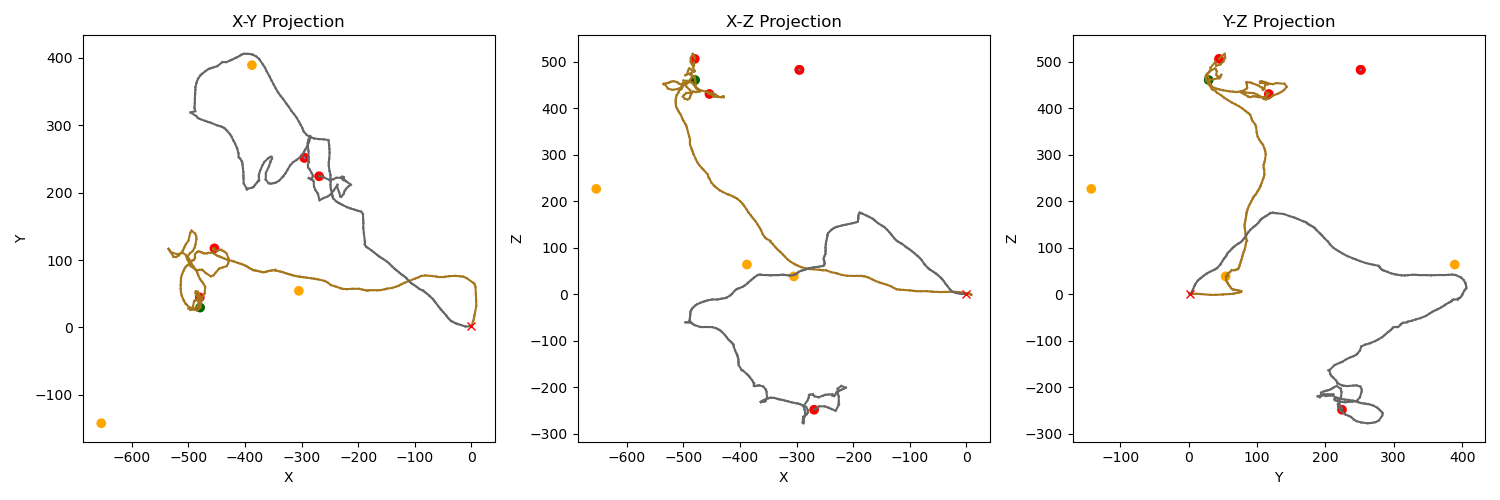

In [43]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', UpdatedTracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', UpdatedTracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', UpdatedTracks)

plt.tight_layout()
plt.show()

### Reconstruction level quantities

In [45]:
track1_energy = 0
track2_energy = 0

# This adds each gamma/track energy to the closest track instead. 
for t in UpdatedTracks:

    if (t["label"] == "Track1"):
        track1_energy = track1_energy + t["energy"]

    if (t["label"] == "Track2"):
        track2_energy = track2_energy + t["energy"]

    if (t["label"] != "Track1" and t["label"] != "Track2" and t["label"] != "vertex"):

        print(t["label"])
        # Get the indexes of closest nodes to start of the gamma
        dist_ind_start = np.argsort(dist_matrix[t["start"]])[1:]

        # Filter nodes that are in the current track
        dist_ind_start = [x for x in dist_ind_start if x not in t["nodes"]]

        found_Track = False

        # Loop over the the closest indexes
        for d_idx in dist_ind_start:

            if (found_Track):
                break

            # Loop over the tracks
            for closest_t in UpdatedTracks:
                if (d_idx in closest_t["nodes"] and closest_t["label"] == "Track1"):
                    # print("Adding Gamma energy", t["energy"] ,"to Track1")
                    track1_energy = track1_energy + t["energy"]
                    found_Track = True
                    break

                if (d_idx in closest_t["nodes"] and closest_t["label"] == "Track2"):
                    # print("Adding Gamma energy", t["energy"] ,"to Track2")
                    track2_energy = track2_energy + t["energy"]
                    found_Track = True
                    break


print("Track 1 Energy:", track1_energy)
print("Track 2 Energy:", track2_energy)
print("Tot Energy:", track1_energy + track2_energy)
Reco_T1 = ReturnLargest(track1_energy,track2_energy)


part = parts[parts.event_id == event_num]
part = part[part.primary == 1]
display(part)

gen_kin_energy = max(part.kin_energy.values) # generator T1


track
Adding Gamma energy 0.029825001023709774 to Track1
gamma
Adding Gamma energy 0.013074999675154686 to Track1
gamma
Adding Gamma energy 0.02032499946653843 to Track2
gamma
Adding Gamma energy 0.01912499964237213 to Track1
Track 1 Energy: 1.2815000039117876
Track 2 Energy: 1.1769750055646
Tot Energy: 2.4584750094763876


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
5969,34,2,e-,1,0,0.0,0.0,0.0,0.0,-284.356384,...,-1.589783,0.110924,0.218228,-0.0,0.0,-0.0,1.176738,1870.536499,none,eIoni
6237,34,1,e-,1,0,0.0,0.0,0.0,0.0,-456.376343,...,0.652614,1.567202,0.262695,0.0,0.0,-0.0,1.281250,1550.500122,none,eIoni


In [46]:
# Calculate the angle between the electrons

### ------------- ------------- ------------- -------------
# Filter particles with particle_id 1 and 2
particle_1 = part[part.particle_id == 1].copy()
particle_2 = part[part.particle_id == 2].copy()

# Merge the DataFrames on 'event' to pair particles from the same event
merged_particles = pd.merge(particle_1, particle_2, on="event_id", suffixes=('_1', '_2'))

# Apply the function to each row in the merged DataFrame
merged_particles['angle'] = merged_particles.apply(calculate_angle_parts, axis=1)
print("True Angle:", merged_particles['angle'].iloc[0])
# ------------- ------------- ------------- -------------

data['Track1'] = 0
data['Track2'] = 0

track1_indices = []
track2_indices = []

for t in UpdatedTracks:

    if t["label"] == "Track1":
        track1_indices = track1_indices + t["nodes"]

    if t["label"] == "Track2":
        track2_indices = track2_indices + t["nodes"]

data.loc[track1_indices, 'Track1'] = 1
data.loc[track2_indices, 'Track2'] = 1

display(data[data.distance < 5])

print(track1_indices)


True Angle: -0.2918157012570399


,x,y,z,energy,distance,Track1,Track2
486,-0.055936,1.713074,0.395807,0.0037,1.759095,1,1


[113, 108, 107, 77, 102, 100, 72, 95, 68, 56, 53, 50, 41, 111, 96, 101, 103, 89, 85, 75, 76, 94, 105, 109, 486, 488, 489, 491, 495, 494, 493, 492, 490, 487, 485, 483, 482, 480, 476, 473, 469, 467, 464, 462, 458, 454, 450, 448, 446, 442, 439, 437, 434, 432, 429, 425, 424, 422, 419, 416, 414, 413, 411, 401, 399, 396, 391, 382, 377, 367, 359, 342, 341, 332, 329, 322, 300, 293, 289, 288, 283, 280, 277, 275, 271, 268, 265, 262, 259, 258, 254, 247, 242, 239, 236, 233, 231, 223, 220, 218, 216, 211, 209, 207, 203, 195, 191, 186, 180, 178, 170, 164, 158, 155, 153, 148, 146, 143, 139, 134, 132, 126, 122, 117, 99, 91, 83, 66, 63, 65, 57, 54, 49, 46, 42, 35, 32, 27, 24, 20, 17, 14, 12, 10, 11, 13, 15, 21, 22, 25, 30, 37, 51, 36, 58, 88, 106, 113, 115, 116, 119, 123, 127, 128, 125, 118, 112, 98, 90, 84, 55, 47, 38, 33, 39, 52, 60, 73, 82, 78, 64, 48, 43, 34, 26, 23, 19, 16, 9, 7, 6, 5, 1, 2, 3, 4, 8, 18, 28, 29, 31, 40, 45, 71, 81, 87, 92, 104, 120, 124, 131, 137, 142, 147, 152, 154, 161, 168, 171,

In [47]:
# Given vertex position
vertex = data[ (data.Track1 == 1) & (data.Track2 == 1)]
vertex = np.array([vertex.iloc[0].x,vertex.iloc[0].y,vertex.iloc[0].z])
vertex = np.array([0,0,0])

# Track1 = data[ (data.Track1 == 1) & (data.Track2 != 1)]
Track1 = data.iloc[trk1_path]
# Track1 = Track1.reindex(track1_indices)
Track1 = Track1.iloc[1:] # remove vertex index

# Track2 = data[ (data.Track2 == 1) & (data.Track1 != 1)]
Track2 = data.iloc[trk2_path]
# Track2 = Track2.reindex(track2_indices)
Track2 = Track2.iloc[1:] # remove vertex index

display(Track1)
display(Track2)

# cos_theta, direction_vector1, direction_vector2 = CalcTrackAngle(Track1.iloc[0:1], Track2.iloc[0:1], vertex)
cos_theta, direction_vector1, direction_vector2 = CalcTrackAngle(Track1, Track2, vertex)

print(cos_theta)

,x,y,z,energy,distance,Track1,Track2
488,3.835210,10.688746,1.216461,0.005125,11.420941,1,0
489,4.926260,15.464525,0.868035,0.000100,16.253401,1,0
491,5.820866,18.780258,0.584055,0.004050,19.670324,1,0
495,8.692142,31.755510,-1.074501,0.015525,32.941162,1,0
494,8.476580,39.580944,-1.061069,0.003175,40.492336,1,0
...,...,...,...,...,...,...,...
156,-442.455383,115.223793,429.162628,0.004350,627.075623,1,0
149,-450.160126,113.848457,433.334595,0.016675,635.125549,1,0
144,-455.060669,114.971771,433.052307,0.000050,638.618042,1,0
141,-456.125214,116.788330,431.823639,0.062250,638.875061,1,0


,x,y,z,energy,distance,Track1,Track2
484,-10.423318,1.366152,1.162772,0.008600,10.576576,0,1
481,-18.289450,3.603354,3.046219,0.002025,18.888292,0,1
479,-23.842226,4.940038,5.363992,0.000100,24.932470,0,1
478,-24.557035,5.149352,5.828563,0.000250,25.759192,0,1
477,-28.438709,6.395163,10.102910,0.007225,30.850075,0,1
...,...,...,...,...,...,...,...
365,-243.696228,219.875885,-243.506180,0.003125,408.691223,0,1
351,-250.421799,218.686844,-240.612717,0.003575,410.401642,0,1
340,-259.942871,222.399414,-240.623962,0.009425,418.248352,0,1
337,-264.988495,224.106827,-245.238861,0.000025,424.952789,0,1


-0.19834264552469774


(-2.0, 2.0)

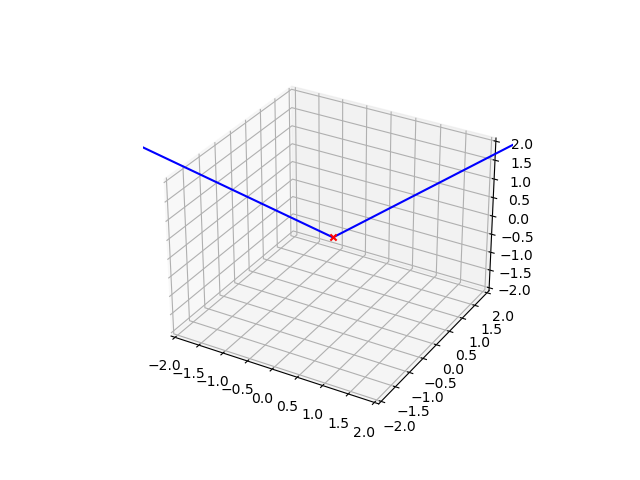

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the original points
# ax.scatter(data.x, data.y, data.z, color='blue')
ax.scatter(vertex[0], vertex[1], vertex[2], color='red', marker="x")
ax.scatter(Track1.x, Track1.y, Track1.z, color='pink')
ax.scatter(Track2.x, Track2.y, Track2.z, color='green')

# Plot the direction vector
vector_line1 = np.array([vertex, vertex + 10*direction_vector1])  # Extend the vector for visualization
vector_line2 = np.array([vertex, vertex + 10*direction_vector2])  # Extend the vector for visualization

ax.plot(vector_line1[:, 0], vector_line1[:, 1], vector_line1[:, 2], color='blue')
ax.plot(vector_line2[:, 0], vector_line2[:, 1], vector_line2[:, 2], color='blue')

ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)